<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-usage" data-toc-modified-id="Example-usage-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example usage</a></span><ul class="toc-item"><li><span><a href="#Read-circuit-and-build-graph" data-toc-modified-id="Read-circuit-and-build-graph-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read circuit and build graph</a></span><ul class="toc-item"><li><span><a href="#Generate-buckets" data-toc-modified-id="Generate-buckets-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Generate buckets</a></span></li><li><span><a href="#Get-graph-from-buckets,-make-clique-on-output-vars" data-toc-modified-id="Get-graph-from-buckets,-make-clique-on-output-vars-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Get graph from buckets, make clique on output vars</a></span></li><li><span><a href="#Get-optimal-peo-with-clique-in-the-end" data-toc-modified-id="Get-optimal-peo-with-clique-in-the-end-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Get optimal peo with clique in the end</a></span></li></ul></li><li><span><a href="#Cost-estimation" data-toc-modified-id="Cost-estimation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cost estimation</a></span></li></ul></li><li><span><a href="#QAOA-usage" data-toc-modified-id="QAOA-usage-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QAOA usage</a></span><ul class="toc-item"><li><span><a href="#Generate-circuit" data-toc-modified-id="Generate-circuit-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate circuit</a></span></li><li><span><a href="#Mixer-operator" data-toc-modified-id="Mixer-operator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Mixer operator</a></span></li><li><span><a href="#Full-QAOA-circuit" data-toc-modified-id="Full-QAOA-circuit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Full QAOA circuit</a></span></li><li><span><a href="#Estimate-cost-for-big-graph" data-toc-modified-id="Estimate-cost-for-big-graph-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Estimate cost for big graph</a></span></li></ul></li></ul></div>

In [1]:
import cirq
import qtree
import matplotlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


# Example usage

In [2]:
def get_test_circ_filename(root, size, depth=10, id_=0):
    grid = f'{size}x{size}'
    return f'{root}/inst/cz_v2/{grid}/inst_{grid}_{depth}_{id_}.txt'

test_file = get_test_circ_filename('./qtree/test_circuits', 4)
test_file

'./qtree/test_circuits/inst/cz_v2/4x4/inst_4x4_10_0.txt'

## Read circuit and build graph

In [35]:
nqubits, circ = qtree.read_circuit_file(test_file)
for layer in circ:
    print(layer)

2020-02-27 14:47:15,242- INFO•	reading file ./qtree/test_circuits/inst/cz_v2/4x4/inst_4x4_10_0.txt
2020-02-27 14:47:15,252- INFO•	There are 16 qubits in circuit


[H(0), H(1), H(2), H(3), H(4), H(5), H(6), H(7), H(8), H(9), H(10), H(11), H(12), H(13), H(14), H(15)]
[cZ(0,1), cZ(6,7), cZ(8,9), cZ(14,15), T(2), T(3), T(4), T(5), T(10), T(11), T(12), T(13)]
[cZ(4,8), cZ(6,10), Y_1_2(0), Y_1_2(1), X_1_2(7), X_1_2(9), Y_1_2(14), X_1_2(15)]
[cZ(1,2), cZ(9,10), T(0), Y_1_2(4), X_1_2(6), T(7), X_1_2(8), T(14), T(15)]
[cZ(0,4), cZ(9,13), cZ(2,6), cZ(11,15), Y_1_2(1), T(8), Y_1_2(10)]
[cZ(2,3), cZ(4,5), cZ(10,11), cZ(12,13), Y_1_2(0), T(1), X_1_2(6), Y_1_2(9), Y_1_2(15)]
[cZ(5,9), cZ(7,11), T(0), X_1_2(2), Y_1_2(3), Y_1_2(4), T(6), Y_1_2(10), Y_1_2(12), X_1_2(13), T(15)]
[cZ(5,6), cZ(13,14), T(2), T(3), T(4), Y_1_2(7), Y_1_2(9), T(10), Y_1_2(11), T(12)]
[cZ(8,12), cZ(1,5), cZ(10,14), cZ(3,7), X_1_2(6), T(9), T(11), X_1_2(13)]
[cZ(0,1), cZ(6,7), cZ(8,9), cZ(14,15), X_1_2(3), Y_1_2(5), Y_1_2(10), Y_1_2(12), T(13)]
[H(0), H(1), H(2), H(3), H(4), H(5), H(6), H(7), H(8), H(9), H(10), H(11), H(12), H(13), H(14), H(15)]


2020-02-27 14:47:15,298- INFO•	Generated graph with 78 nodes and 115 edges


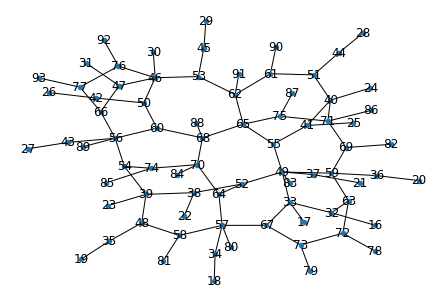

In [36]:
graph = qtree.graph_model.circ2graph(nqubits, circ)
nx.draw_kamada_kawai(graph, node_size=20, with_labels=True)

### Generate buckets

In [37]:
buckets, data_dict, bra, ket = \
    qtree.optimizer.circ2buckets(nqubits, circ)
print(bra, ket)

[o_0, o_1, o_2, o_3, o_4, o_5, o_6, o_7, o_8, o_9, o_10, o_11, o_12, o_13, o_14, o_15] [i_0, i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, i_11, i_12, i_13, i_14, i_15]


### Get graph from buckets, make clique on output vars

In [38]:
graph_initial = qtree.graph_model.buckets2graph(
    buckets, ignore_variables=ket)

graph_full = qtree.graph_model.make_clique_on(graph_initial, bra)

2020-02-27 14:47:15,843- INFO•	Clique of size 16 on vertices: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)


<IPython.core.display.Javascript object>


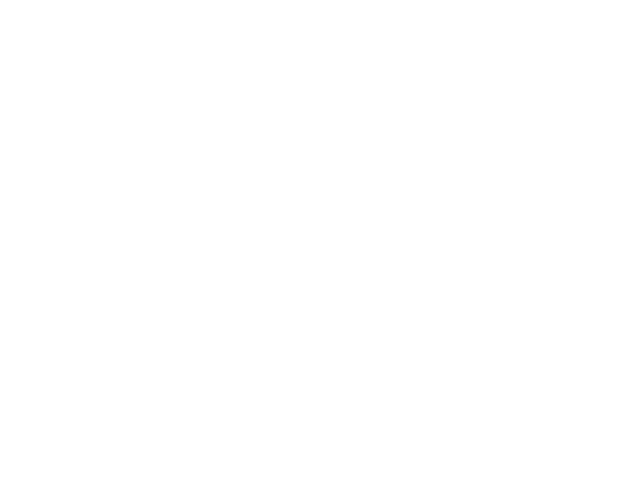

In [39]:
%matplotlib notebook 

def draw_graph(graph):
    layout = nx.kamada_kawai_layout(graph)
    nx.draw_networkx_nodes(graph, layout, node_size=5)
    nx.draw_networkx_edges(graph, layout)
    nx.draw_networkx_labels(graph, layout)
    
draw_graph(graph_full)

In [40]:
%matplotlib inline

### Get optimal peo with clique in the end

In [41]:

qtree.simulator.eval_contraction_cost(test_file)

2020-02-27 14:47:16,332- INFO•	reading file ./qtree/test_circuits/inst/cz_v2/4x4/inst_4x4_10_0.txt
2020-02-27 14:47:16,334- INFO•	There are 16 qubits in circuit
2020-02-27 14:47:16,467- INFO•	generating config file output/quickbb.90611264.cnf
2020-02-27 14:47:16,468- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.90611264.cnf 
2020-02-27 14:47:16,649- INFO•	Removed indices by parallelization:
[49, 46, 57, 56, 33]
2020-02-27 14:47:16,650- INFO•	Removed 5 variables
2020-02-27 14:47:16,656- INFO•	generating config file output/quickbb.86296451.cnf
2020-02-27 14:47:16,657- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.86296451.cnf 


treewidth 4
Memory (in doubles):
 raw: 3.706e+06
 optimized: 2.268e+04
 parallel:
  node: 1.709e+04 total: 5.468e+05 n_tasks: 32


In [42]:
peo, tw = qtree.graph_model.get_peo(graph_full)
new_peo = qtree.graph_model.get_equivalent_peo(graph_full, peo, bra)
print(tw, new_peo)

2020-02-27 14:47:16,909- INFO•	generating config file output/quickbb.37580660.cnf
2020-02-27 14:47:16,910- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.37580660.cnf 


16 [v_80, v_83, v_84, v_89, v_91, v_88, v_86, v_81, v_85, v_93, v_92, v_87, v_82, v_90, v_79, v_78, v_24, v_30, v_18, v_34, v_21, v_37, v_23, v_27, v_43, v_20, v_36, v_17, v_25, v_72, v_73, v_16, v_28, v_44, v_61, v_29, v_45, v_22, v_26, v_42, v_69, v_75, v_76, v_77, v_31, v_74, v_19, v_35, v_58, v_48, v_54, v_47, v_66, v_71, v_50, v_68, v_38, v_64, v_53, v_51, v_32, v_67, v_55, v_41, v_63, v_62, v_52, v_60, v_33, v_59, v_56, v_70, v_39, v_49, v_57, v_65, v_46, v_40, o_0, o_1, o_2, o_3, o_4, o_5, o_6, o_7, o_8, o_9, o_10, o_11, o_12, o_13, o_14, o_15]


## Cost estimation

In [13]:
def get_graph_from_file(test_file):
    nqubits, circ = qtree.read_circuit_file(test_file)
    return get_graph_from_circ(nqubits, circ)
    
def get_graph_from_circ(nqubits, circ):
    buckets, data_dict, bra, ket = \
        qtree.optimizer.circ2buckets(nqubits, circ)
    
    graph_initial = get_single_amp_graph(nqubits, circ)
    graph_full = qtree.graph_model.make_clique_on(graph_initial, bra)
    # TODO: refactor so no need to return this
    return graph_full, bra, ket

def get_single_amp_graph_from_file(test_file):
    nqubits, circ = qtree.read_circuit_file(test_file)
    return get_graph_from_circ(nqubits, circ)

def get_single_amp_graph(nqubits, circ):
    ### Generate buckets
    buckets, data_dict, bra, ket = \
        qtree.optimizer.circ2buckets(nqubits, circ)
    
    graph = qtree.graph_model.circ2graph(nqubits, circ)
    graph_initial = qtree.graph_model.buckets2graph(
        buckets, ignore_variables=ket)
    return graph_initial


def generate_peo_single(graph_full):
    peo, tw = qtree.graph_model.get_peo(graph_full)
    return peo, tw
    
def generate_peo(graph_full, bra):
    peo, tw = generate_peo_single(graph_full)
    new_peo = qtree.graph_model.get_equivalent_peo(graph_full, peo, bra)
    return new_peo, tw

def reorder_graph(graph, peo):
    graph, label_dict = qtree.graph_model.relabel_graph_nodes(
        graph, dict(zip(peo, sorted(graph.nodes(), key=int)))
    )
    return graph

def optimize_graph(graph, bra):
    peo, tw = generate_peo(graph, bra)
    return reorder_graph(graph, peo)

In [14]:
def plot_cost(mems, flops):
    plt.yscale('log')
    ax = plt.gca()
    ax.grid(which='minor', alpha=0.5, linestyle='-', axis='both')
    ax.grid(which='major', alpha=0.6, axis='both')
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.minorticks_on()
    
    plt.plot(mems, label='Memory')
    plt.plot(flops, label='FLOP')
    plt.legend()
    
def cost_graph(graph_full, title):
    mems, flops = qtree.graph_model.cost_estimator(graph_full)
    buckets = qtree.optimizer.graph2buckets(graph_full)
    plt.title(title)
    plot_cost(mems, flops)
    plt.plot([len(x) for x in buckets])
    print(title, '{:.3e}'.format(sum(flops)))

2020-02-28 23:39:18,314- INFO•	reading file ./qtree/test_circuits//inst/cz_v2/6x6/inst_6x6_10_0.txt
2020-02-28 23:39:18,315- INFO•	There are 36 qubits in circuit
2020-02-28 23:39:18,325- INFO•	Generated graph with 178 nodes and 264 edges
2020-02-28 23:39:18,352- INFO•	Clique of size 36 on vertices: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35)
2020-02-28 23:39:20,038- INFO•	generating config file output/quickbb.15781565.cnf
2020-02-28 23:39:20,039- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.15781565.cnf 


full state, naive 6.734e+15
full state, with equivalent peo 1.010e+13


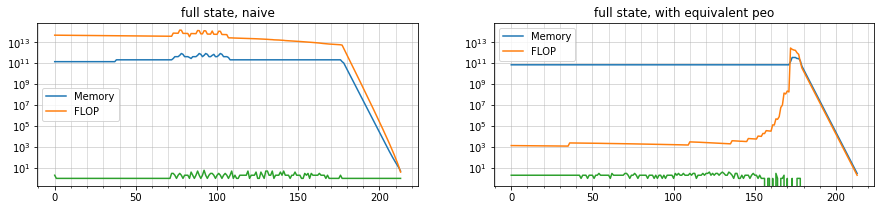

In [15]:
f, axs = plt.subplots(1,2, sharey=True, figsize=(15,3))
graph_full, bra, ket= get_graph_from_file(test_file)             

plt.sca(axs[0])
cost_graph(graph_full, 'full state, naive')
graph_full = optimize_graph(graph_full, bra)

plt.sca(axs[1])
cost_graph(graph_full, 'full state, with equivalent peo')


,178,91,179,68,180,52,181,42,182,85,...,25,26,29,17,28,35,27,24,22,23
178,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


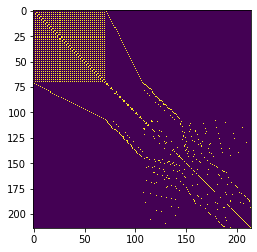

In [16]:
plt.imshow(nx.to_pandas_adjacency(graph_full))
(nx.to_pandas_adjacency(graph_full))

# QAOA usage

## Generate circuit

In [ ]:
w = np.array([[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]])
G = nx.from_numpy_matrix(w)
nx.draw(G)

In [ ]:
def append_zz_term(qc, q1, q2, gamma):
    layer = []
    layer.append(qtree.operators.cX(q1, q2))
    layer.append(qtree.operators.ZPhase(q2, alpha=2*gamma))
    layer.append(qtree.operators.cX(q1, q2))
    qc.append(layer)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = list()
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc

In [ ]:
qc = get_cost_operator_circuit(G, np.pi/3)
cirq_qc = qtree.cirq.parse_circuit_1d(qc)
cirq_qc

## Mixer operator

In [ ]:
def append_x_term(qc, q1, beta):
    layer = []
    layer.append(qtree.operators.H(q1))
    layer.append(qtree.operators.ZPhase(q1, alpha=2*beta))
    layer.append(qtree.operators.H(q1))
    qc.append(layer)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = []
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

In [ ]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qtree.cirq.parse_circuit_1d(qc)

## Full QAOA circuit

In [ ]:
def layer_of_Hadamards(qc,N):
    layer = []
    for q in range(N):
        layer.append(qtree.operators.H(q))
    qc.append(layer)
        
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = []
    layer_of_Hadamards(qc, N)
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    return qc

In [ ]:
qc = get_qaoa_circuit(G, [np.pi/3], [np.pi/2])
cirq_qc = qtree.cirq.parse_circuit_1d(qc)
cirq_qc

In [ ]:
amplitudes, slice_dict = qtree.simulator.simulate_multiamp_np(G.number_of_nodes(), qc)

In [ ]:
amplitudes


In [ ]:
probs = np.abs(np.power(amplitudes, 2))
plt.plot(probs)

## Estimate cost for big graph

/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


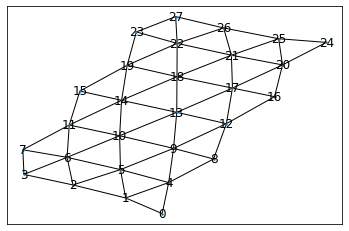

In [124]:
S = 6
G = nx.triangular_lattice_graph(S, S)
gen = (x for x in range(G.number_of_nodes()))
G = nx.relabel_nodes(G, lambda x: next(gen))
nx.draw_networkx(G, node_size=2)

2020-02-27 18:02:27,110- INFO•	Generated graph with 238 nodes and 553 edges


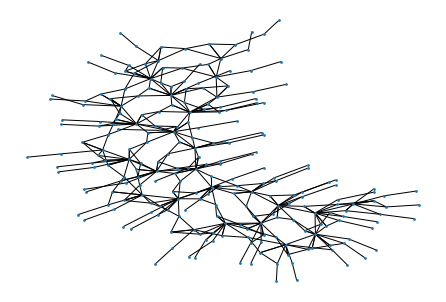

In [125]:
qc = get_qaoa_circuit(G, [np.pi/3], [np.pi/2])
N = G.number_of_nodes()
graph = qtree.graph_model.circ2graph(N, qc)
nx.draw_kamada_kawai(graph, node_size=3)

2020-02-27 15:21:24,871- INFO•	Generated graph with 238 nodes and 553 edges
/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py:513: RuntimeWarning: overflow encountered in long_scalars
  flops = (size_of_the_result *
/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py:503: RuntimeWarning: overflow encountered in long_scalars
  memory += mem
<ipython-input-90-570e2adf073b>:19: RuntimeWarning: overflow encountered in long_scalars
  print(title, '{:.3e}'.format(sum(flops)))
2020-02-27 15:21:30,699- INFO•	generating config file output/quickbb.48647530.cnf
2020-02-27 15:21:30,700- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.48647530.cnf 


full state, naive 1.512e+18
Treewidth: 4
full state, with equivalent peo 6.072e+05


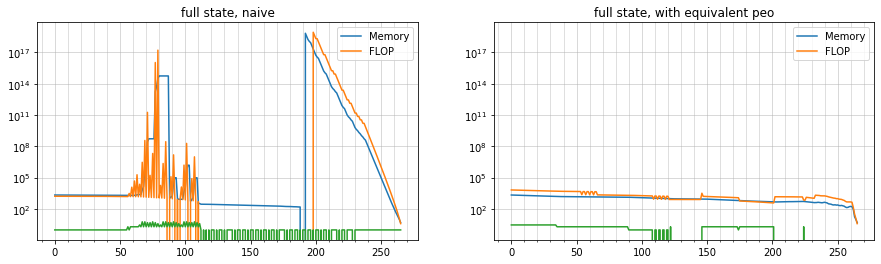

In [103]:
f, axs = plt.subplots(1,2, sharey=True, figsize=(15,4))

graph_full = get_single_amp_graph(N, qc)
plt.sca(axs[0])
cost_graph(graph_full, 'full state, naive')
peo, tw = generate_peo_single(graph_full)
print('Treewidth:', tw)
graph_full = reorder_graph(graph_full, peo)

plt.sca(axs[1])
cost_graph(graph_full, 'full state, with equivalent peo')

In [126]:
def prepare_triangular_graph(S):
    G = nx.triangular_lattice_graph(S, S)
    gen = (x for x in range(G.number_of_nodes()))
    G = nx.relabel_nodes(G, lambda x: next(gen))
    return G

def get_triangular_qaoa_circ_graph(S):
    G = prepare_triangular_graph(S)
    N = G.number_of_nodes()
    print('Number of nodes:', N)
    
    qc = get_qaoa_circuit(G, [np.pi/3], [np.pi/2])
    for i in range(4):
        qc += get_qaoa_circuit(G, [np.pi/3], [np.pi/2])
    
    graph = qtree.graph_model.circ2graph(N, qc)

    graph_full = get_single_amp_graph(N, qc)
    return graph_full


In [128]:
sizes = np.arange(8, 15)
for s in sizes:
    graph = get_triangular_qaoa_circ_graph(s)
    
    while True:
        try:
            peo, tw = generate_peo_single(graph)
            break
        except TypeError:
            print('Peo is None! retrying...')
            
    treewidths.append(tw)
    graph_full = reorder_graph(graph, peo)
    mems, flops = qtree.graph_model.cost_estimator(graph_full)
    mems_flops.append([mems, flops])


2020-02-27 18:49:03,773- INFO•	Generated graph with 1800 nodes and 4680 edges
2020-02-27 18:49:03,870- INFO•	Generated graph with 1800 nodes and 4680 edges


Number of nodes: 45


2020-02-27 18:49:04,894- INFO•	generating config file output/quickbb.66660975.cnf
2020-02-27 18:49:04,898- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.66660975.cnf 
2020-02-27 18:52:05,329- INFO•	Generated graph with 2230 nodes and 5825 edges
2020-02-27 18:52:05,428- INFO•	Generated graph with 2230 nodes and 5825 edges


Number of nodes: 55


2020-02-27 18:52:05,735- INFO•	generating config file output/quickbb.92945067.cnf
2020-02-27 18:52:05,739- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.92945067.cnf 


Peo is None! retrying...


2020-02-27 18:57:21,185- INFO•	generating config file output/quickbb.82019550.cnf
2020-02-27 18:57:21,203- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.82019550.cnf 


Peo is None! retrying...


2020-02-27 19:02:31,032- INFO•	generating config file output/quickbb.13187050.cnf
2020-02-27 19:02:31,049- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.13187050.cnf 


Peo is None! retrying...


2020-02-27 19:07:52,291- INFO•	generating config file output/quickbb.56246292.cnf
2020-02-27 19:07:52,303- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.56246292.cnf 


KeyboardInterrupt: 

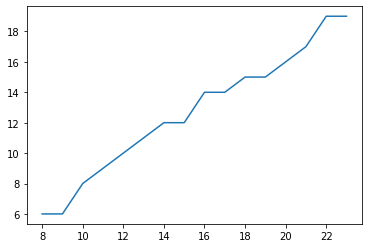

In [123]:
plt.plot(range(8,24), treewidths)